## Dataset for model

In [1]:
import warnings
warnings.filterwarnings('ignore')

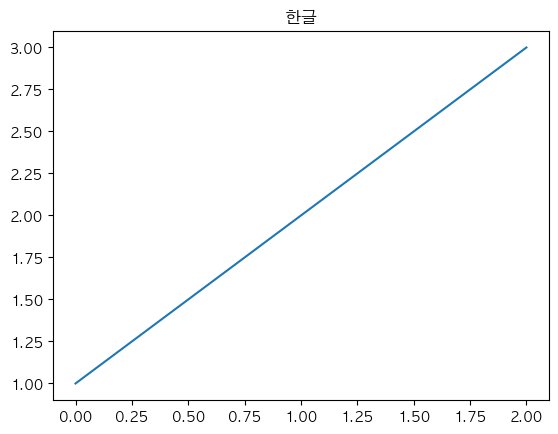

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family="AppleGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

### 0. 데이터 로드

In [3]:
import pandas as pd

df = pd.read_csv('../data/울산_전처리_ver6.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72139 entries, 0 to 72138
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   호출부호                72139 non-null  object 
 1   입항일시                72139 non-null  object 
 2   출항일시                72139 non-null  object 
 3   접안_대기시간_분           72139 non-null  int64  
 4   출항_대기시간_분           72139 non-null  float64
 5   Service_Time_Start  72139 non-null  object 
 6   Service_Time_End    72139 non-null  object 
 7   계선장소_코드             72139 non-null  object 
 8   계선장소_숫자             72139 non-null  int64  
 9   계선장소명               72139 non-null  object 
 10  선박용도                72139 non-null  object 
 11  Service_Time_분      72139 non-null  float64
 12  대기율                 72114 non-null  float64
 13  총톤수                 61615 non-null  object 
 14  재화중량톤수              59935 non-null  object 
 15  선박제원(총길이, m)        71527 non-null  float64
 16  선박제원

#### 이상치
- 입항일시와 출항일시가 20,21,22 밖에 있는 행은 사전에 제거함

#### 1. EDA

In [5]:
df.drop(columns = '일시', inplace = True)

#### 1.1 선박 용도별 접안_대기시간_계산
- 운반선, 컨테이너선 / 비컨테이너,운반선간 대기율 차이가 존재할 것
- 각각 접안_대기시간 계산 후 비교
- 0인 용도 제외 시계열 데이터 예측

In [6]:
df['선박용도'].value_counts()

석유제품 운반선       35977
케미칼 운반선         9831
풀컨테이너선          4123
견인용예선           3799
LPG 운반선         3503
일반화물선           3314
기타 예선           1819
기타 유조선          1659
산물선(벌크선)        1520
자동차운반선          1454
원유운반선           1449
급유선             1338
시멘트운반선           531
기타선              466
케미칼가스 운반선        346
압항 예선            192
모래운반선            178
이.접안용 예선         125
철강재 운반선          114
신조선               95
폐기물 운반선           86
관공선               55
LNG 운반선           52
코일전용선             41
용달선               29
세미(혼재)컨테이너선       26
여객선                7
군함                 3
원양 어선              1
유람선                1
원목운반선              1
화객선                1
수상레저기구             1
기타 부선              1
냉동.냉장선             1
Name: 선박용도, dtype: int64

In [7]:
ship_mapping = df.groupby('선박용도')['접안_대기시간_분'].mean()

In [8]:
ship_mapping = ship_mapping.to_frame().reset_index()

In [9]:
df_sorted = ship_mapping.sort_values(by='접안_대기시간_분', ascending=False)

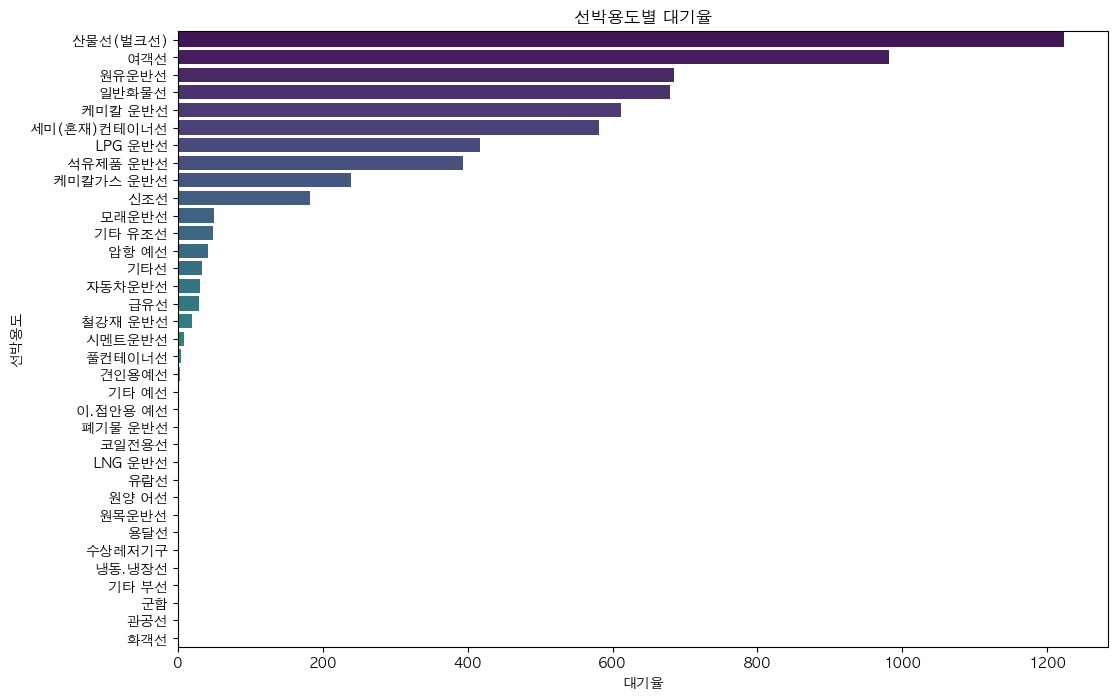

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='접안_대기시간_분', y='선박용도', data=df_sorted, palette='viridis', ax=ax)
ax.set_title('선박용도별 대기율')
ax.set_xlabel('대기율')
ax.set_ylabel('선박용도')

# Show the plot
plt.show()

In [11]:
ship_rank = ship_mapping[ship_mapping['접안_대기시간_분'] > 0.0].sort_values(by = '접안_대기시간_분', ascending = False)

In [12]:
ship_rank.reset_index()

,index,선박용도,접안_대기시간_분
0,12,산물선(벌크선),1222.870395
1,19,여객선,981.428571
2,23,원유운반선,684.171843
3,26,일반화물선,679.856367
4,29,케미칼 운반선,611.861764
5,14,세미(혼재)컨테이너선,581.076923
6,1,LPG 운반선,416.967742
7,13,석유제품 운반선,392.805904
8,30,케미칼가스 운반선,238.780347
9,17,신조선,181.652632


#### 1.2 선석별 대기시간 차이
- 선석 기준 대기시간 예측 > row개수 115개

In [13]:
service_place = df.groupby('계선장소명')['접안_대기시간_분'].mean()

In [14]:
service_place = service_place.to_frame().reset_index()

In [15]:
service_place.sort_values(by = '접안_대기시간_분', ascending = False, inplace = True)
service_place

,계선장소명,접안_대기시간_분
38,SK7부두,2590.667598
82,온산3부두,2550.492375
62,석탄부두 01,2026.698745
39,SK8부두,1693.318841
24,S-OIL 4부두 03,1393.666667
...,...,...
29,S-OIL부이 02,0.000000
51,매암소형선부두,0.000000
92,일반부두 01,0.000000
84,용연물양장,0.000000


In [16]:
service_place.reset_index()

,index,계선장소명,접안_대기시간_분
0,38,SK7부두,2590.667598
1,82,온산3부두,2550.492375
2,62,석탄부두 01,2026.698745
3,39,SK8부두,1693.318841
4,24,S-OIL 4부두 03,1393.666667
...,...,...,...
130,29,S-OIL부이 02,0.000000
131,51,매암소형선부두,0.000000
132,92,일반부두 01,0.000000
133,84,용연물양장,0.000000


In [20]:
service_delay = service_place[service_place['접안_대기시간_분'] > 0.00]

In [21]:
service_delay

,계선장소명,접안_대기시간_분
38,SK7부두,2590.667598
82,온산3부두,2550.492375
62,석탄부두 01,2026.698745
39,SK8부두,1693.318841
24,S-OIL 4부두 03,1393.666667
...,...,...
124,현대미포의장안벽 01,1.941176
122,한진부두,1.458333
83,온산4부두,0.998012
41,SK부이 03,0.924855


#### 1.4 접안_대기시간_분 Corr()
- 의미 없음

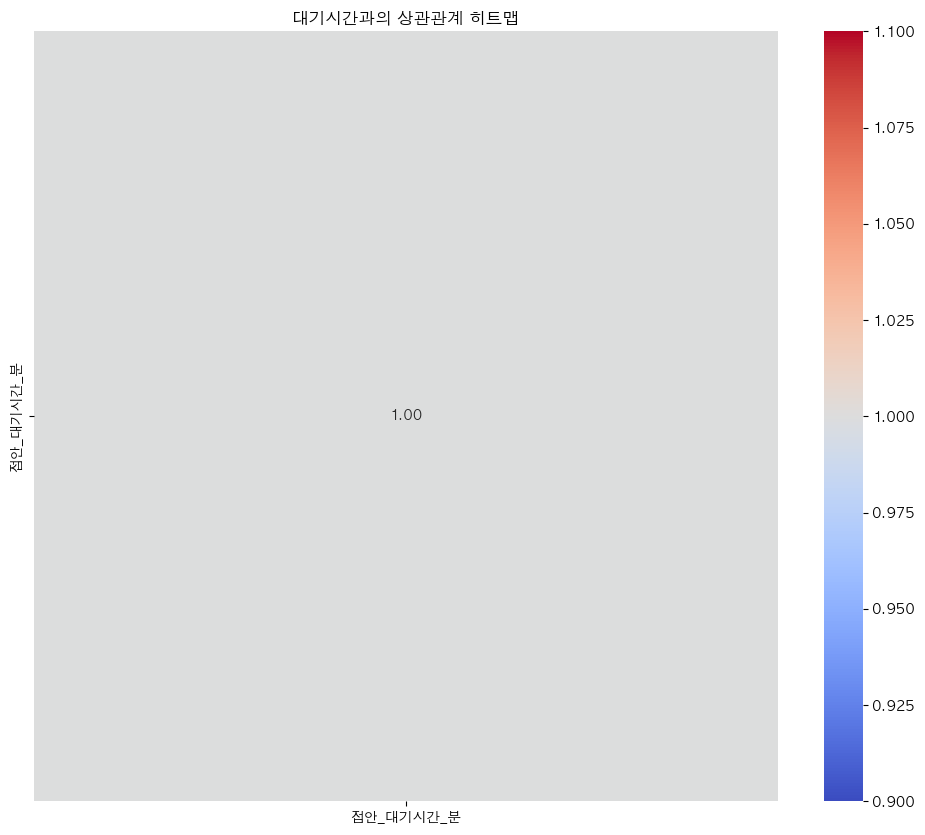

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 대기시간과의 상관관계 계산
correlation_matrix = df.corr()

# 대기시간과 상관관계가 0.0이상인 변수들 선택
high_corr_columns = correlation_matrix['접안_대기시간_분'][abs(correlation_matrix['접안_대기시간_분']) >= 0.2].index

# 선택된 변수들로 새로운 데이터프레임 생성
selected_df = df[high_corr_columns]

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('대기시간과의 상관관계 히트맵')
plt.show()

### 2. 시계열 예측 모델 데이터셋 구성

- 단순 컬럼 세팅

In [24]:
df.columns

Index(['호출부호', '입항일시', '출항일시', '접안_대기시간_분', '출항_대기시간_분', 'Service_Time_Start',
       'Service_Time_End', '계선장소_코드', '계선장소_숫자', '계선장소명', '선박용도',
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '만재흘수(m)', '깊이(m)', '길이1(m)', '선박국적(code)', '선박국적(이름)', 'ETA_Year',
       'ETA_Month', 'ETA_Day', 'ETA_Hour', 'ETA_Minute', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)'],
      dtype='object')

In [25]:
cols = ['입항일시','접안_대기시간_분','풍속(m/s)','기온(°C)','선박제원(총길이, m)', '선박제원(너비, m)']
temp = df[cols]

In [26]:
temp

,입항일시,접안_대기시간_분,풍속(m/s),기온(°C),"선박제원(총길이, m)","선박제원(너비, m)"
0,2020-01-05 11:30:00,1125,3.1,10.3,73.2,12.5
1,2020-02-27 08:50:00,0,9.5,8.9,73.2,12.5
2,2020-03-09 12:35:00,0,3.5,13.8,73.2,12.5
3,2020-03-23 17:10:00,0,7.8,15.5,73.2,12.5
4,2021-07-03 16:20:00,0,NaN,NaN,28.5,8.8
...,...,...,...,...,...,...
72134,2021-04-08 09:18:00,0,NaN,15.9,249.9,44
72135,2021-02-18 10:36:00,9918,10.4,-3.4,249.9,44
72136,2020-06-13 22:00:00,0,8.3,23.1,174.4,27.7
72137,2020-12-10 03:00:00,1789,1.9,11.2,111.5,17


In [27]:
temp.isna().sum()

입항일시               0
접안_대기시간_분          0
풍속(m/s)         6874
기온(°C)          2825
선박제원(총길이, m)     612
선박제원(너비, m)      612
dtype: int64

In [28]:
temp.dropna(inplace = True)

- 데이터셋2

In [29]:
# 문자열 컬럼 제거
string_columns = df.select_dtypes(include=['object']).columns
temp2 = df.drop(columns=string_columns)

In [30]:
temp2.columns

Index(['접안_대기시간_분', '출항_대기시간_분', '계선장소_숫자', 'Service_Time_분', '대기율',
       '선박제원(총길이, m)', '만재흘수(m)', '깊이(m)', '길이1(m)', 'ETA_Year', 'ETA_Month',
       'ETA_Day', 'ETA_Hour', 'ETA_Minute', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)'],
      dtype='object')

In [36]:
drop_cols = ['Service_Time_분','대기율']
temp2 = temp2.drop(columns = drop_cols)

### 시계열 예측 모델

#### Holt-Winters Exponential Smoothing 

In [37]:
df = temp.copy()

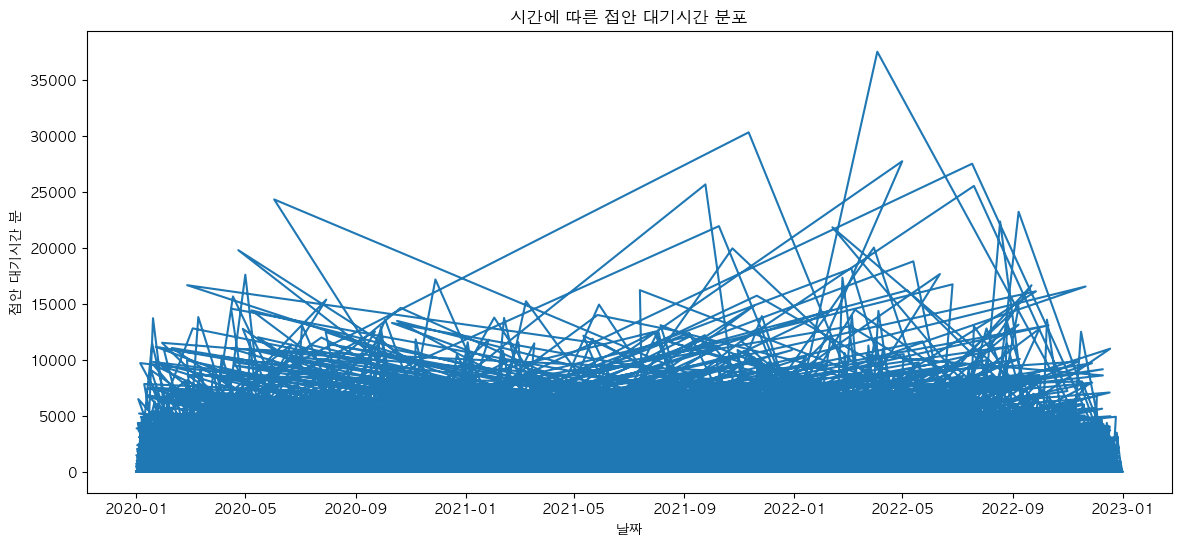

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


평균 제곱 오차(MSE): 3441745.2882442856
제곱근 평균 제곱 오차(RMSE): 1855.1941376158684


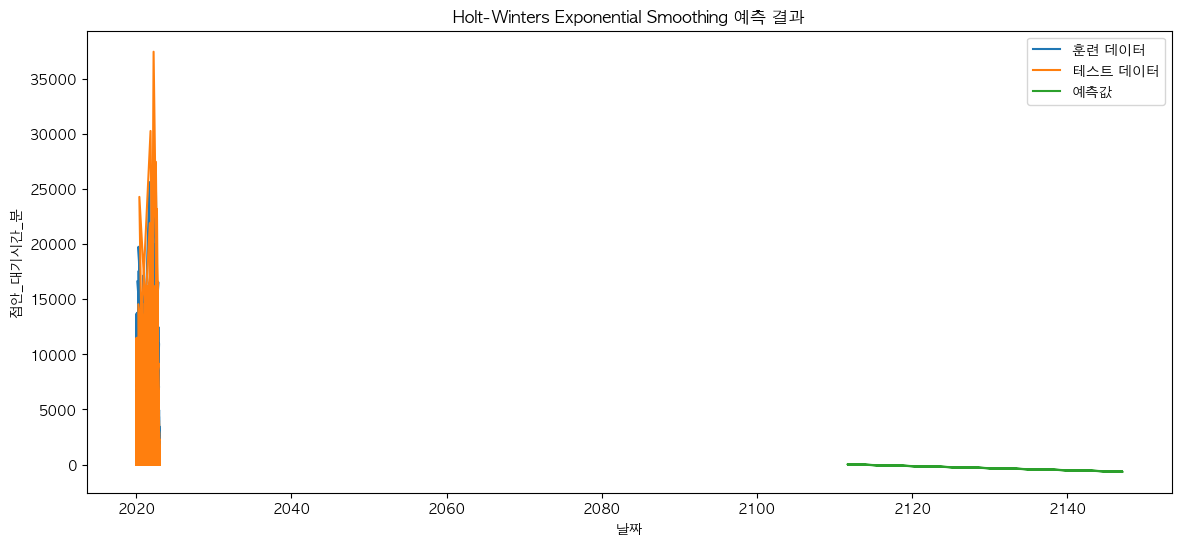

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

df['입항일시'] = pd.to_datetime(df['입항일시'])

df.set_index('입항일시', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df['접안_대기시간_분'])
plt.title('시간에 따른 접안 대기시간 분포')
plt.xlabel('날짜')
plt.ylabel('접안 대기시간 분')
plt.show()

# 훈련8 테스트2
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Holt-Winters Exponential Smoothing 
model = ExponentialSmoothing(train['접안_대기시간_분'], trend='add', seasonal='add', seasonal_periods=24)
model_fit = model.fit(optimized=True)

# 예측
predictions = model_fit.forecast(steps=len(test))

# 모델 평가
mse = mean_squared_error(test['접안_대기시간_분'], predictions)
rmse = np.sqrt(mse)
print(f'평균 제곱 오차(MSE): {mse}')
print(f'제곱근 평균 제곱 오차(RMSE): {rmse}')

# 비교
plt.figure(figsize=(14, 6))
plt.plot(train['접안_대기시간_분'], label='훈련 데이터')
plt.plot(test['접안_대기시간_분'], label='테스트 데이터')
plt.plot(predictions, label='예측값')
plt.title('Holt-Winters Exponential Smoothing 예측 결과')
plt.xlabel('날짜')
plt.ylabel('접안_대기시간_분')
plt.legend()
plt.show()


In [41]:
df = temp.copy()

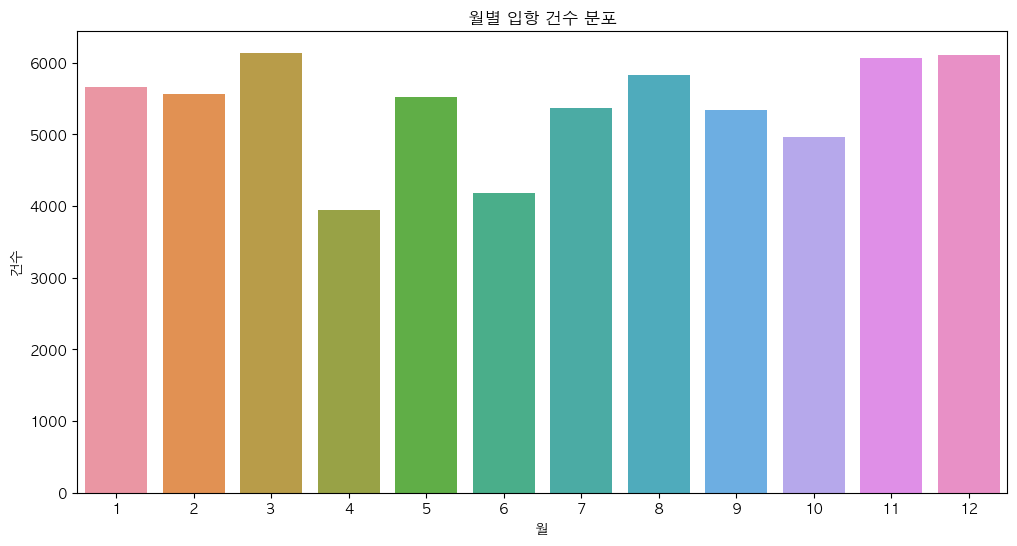

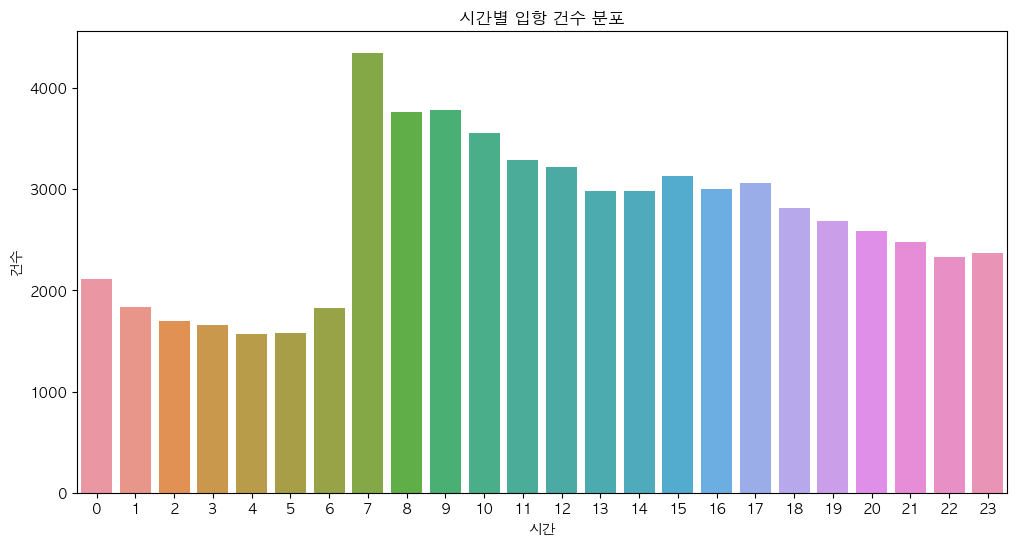

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['입항일시'] = pd.to_datetime(df['입항일시'])

# '월'과 '시간' 정보를 추출합니다.
df['월'] = df['입항일시'].dt.month
df['시간'] = df['입항일시'].dt.hour

# 월별 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
sns.countplot(x='월', data=df)
plt.title('월별 입항 건수 분포')
plt.xlabel('월')
plt.ylabel('건수')
plt.show()

# 시간별 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
sns.countplot(x='시간', data=df)
plt.title('시간별 입항 건수 분포')
plt.xlabel('시간')
plt.ylabel('건수')
plt.show()


#### 주기성 확인

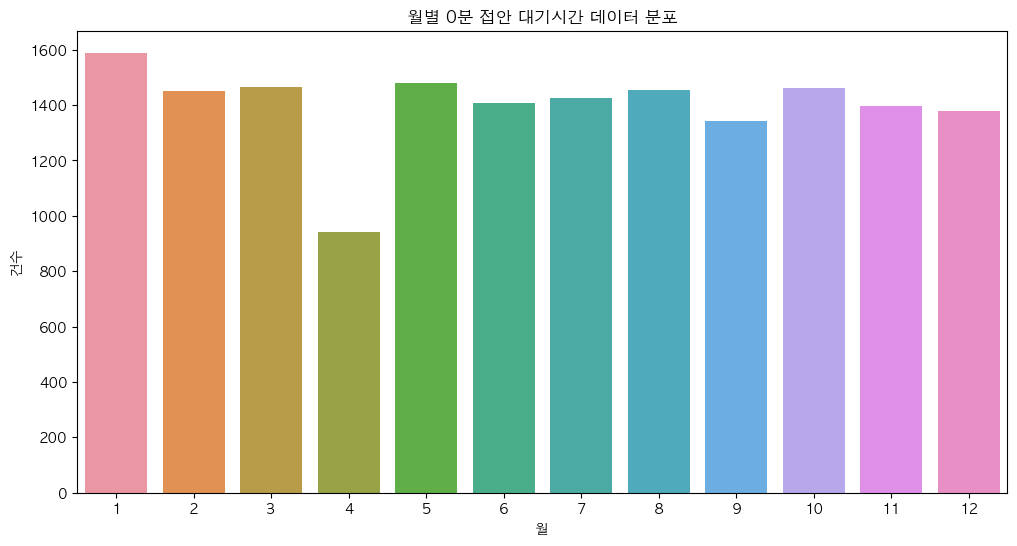

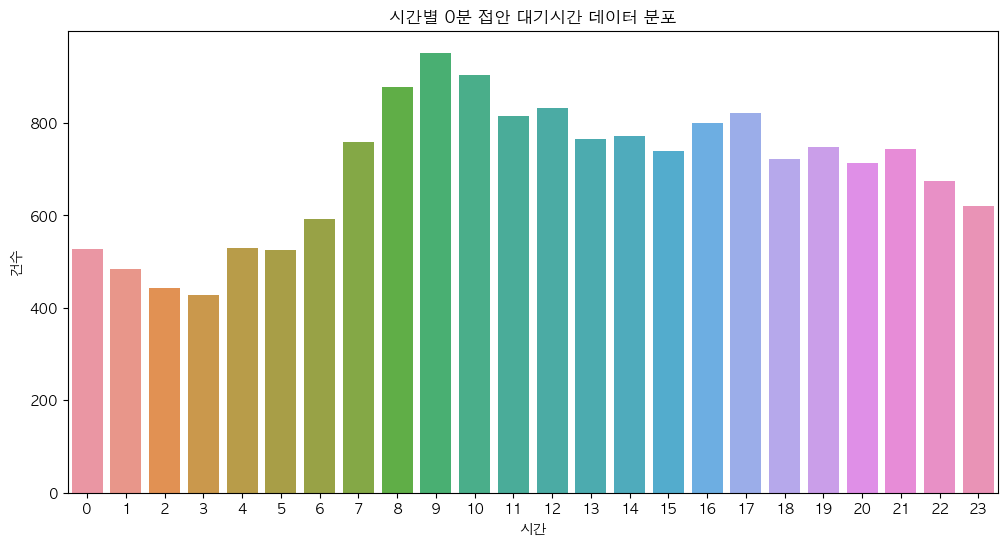

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 타입
df['입항일시'] = pd.to_datetime(df['입항일시'])
df['월'] = df['입항일시'].dt.month
df['시간'] = df['입항일시'].dt.hour

# 접안 대기시간이 발생하는 것만 시각화
zero_wait_time_df = df[df['접안_대기시간_분'] > 0]

# '접안_대기시간_분'이 0인 데이터의 월별 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
sns.countplot(x='월', data=zero_wait_time_df)
plt.title('월별 0분 접안 대기시간 데이터 분포')
plt.xlabel('월')
plt.ylabel('건수')
plt.show()

# '접안_대기시간_분'이 0인 데이터의 시간별 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
sns.countplot(x='시간', data=zero_wait_time_df)
plt.title('시간별 0분 접안 대기시간 데이터 분포')
plt.xlabel('시간')
plt.ylabel('건수')
plt.show()


#### LSTM

In [33]:
df = temp.copy()

In [34]:
temp.isna().sum()

입항일시            0
접안_대기시간_분       0
풍속(m/s)         0
기온(°C)          0
선박제원(총길이, m)    0
선박제원(너비, m)     0
dtype: int64

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


df['입항일시'] = pd.to_datetime(df['입항일시'])

# '접안_대기시간_분'이 0인 데이터만 선택
zero_wait_time_df = df[df['접안_대기시간_분'] == 0]

# 시계열 데이터_ '입항일시'를 인덱스로 설정
zero_wait_time_df.set_index('입항일시', inplace=True)

# LSTM 모델에 사용할 feature '접안_대기시간_분' 추출
data = zero_wait_time_df['접안_대기시간_분'].values.reshape(-1, 1)

# Min-Max 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 학습 데이터와 테스트 데이터 분리
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# X, y 데이터 생성
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12  # 12개 이전 데이터 사용
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# LSTM 데이터 변환
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# 모델 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 역 스케일링
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# 학습, 테스트데이터 준비
train_actual = scaler.inverse_transform([y_train])
test_actual = scaler.inverse_transform([y_test])

# 평가지표
mse_train = mean_squared_error(train_actual[0], train_predict[:, 0])
mse_test = mean_squared_error(test_actual[0], test_predict[:, 0])

print(f'Training Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')

# 시각화 데이터셋 구성
train_size = len(train_actual[0])
test_size = len(test_actual[0])
train_predict_plot = np.empty_like(data_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:train_size, :] = train_predict

test_predict_plot = np.empty_like(data_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[train_size + look_back:len(data_scaled), :] = test_predict

# 원본, 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Data')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Test Predictions')
plt.title('LSTM 모델을 사용한 접안 대기시간 예측')
plt.xlabel('시간')
plt.ylabel('접안 대기시간 분')
plt.legend()
plt.show()


2023-11-14 15:45:20.183757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1231/1231 - 7s - loss: 0.0000e+00 - 7s/epoch - 6ms/step
Epoch 2/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 3/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 4/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 5/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 6/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 7/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 8/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 9/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 10/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 11/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 12/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 13/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 14/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch - 4ms/step
Epoch 15/50
1231/1231 - 5s - loss: 0.0000e+00 - 5s/epoch 

ValueError: could not broadcast input array from shape (39364,1) into shape (39352,1)